In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import KFold
import math

from sklearn.svm import SVC
from sklearn import metrics
from sklearn import ensemble
from sklearn import neighbors
from sklearn import feature_selection

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import sklearn

import statsmodels as sm

import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model

import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns


In [2]:
from keras.utils import to_categorical


# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [4]:
INPUT_FILEPATH = "adult.csv"

TARGET = "income"

N_FOLDS = 10

In [5]:
# Leitura do dataset para um DataFrame do Pandas
# (neste caso ele usa o separador default que eh a virgula)
df = pd.read_csv(INPUT_FILEPATH)

# Remove colunas que nao serao usadas
#df = df.drop(["Date", "Location", "RISK_MM"], axis=1)

# Imprime algumas informacoes basicas sobre os dados
print("Numero de linhas: {}".format(df.shape[0]))
print("Numero de colunas: {}".format(df.shape[1]))

# Para tratar dados faltantes
df = df.replace('?',np.nan)
print("Dados faltando: {}".format(df.isna().sum().sum()))

print("\nAmostra:")
with pd.option_context("max_columns", 12): # Limita o numero de cols mostradas
    display(df.head(20))
    
features = list(df.columns)
features.remove(TARGET)

print("Target: {}".format(TARGET))
print("Features:")
print("\n".join(["  " + x for x in features]))


Numero de linhas: 48842
Numero de colunas: 15
Dados faltando: 6465

Amostra:


,age,workclass,fnlwgt,education,educational-num,marital-status,...,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,...,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,...,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,...,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,...,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,...,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,...,Male,0,0,30,United-States,<=50K
6,29,NaN,227026,HS-grad,9,Never-married,...,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,...,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,...,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,...,Male,0,0,10,United-States,<=50K


Target: income
Features:
  age
  workclass
  fnlwgt
  education
  educational-num
  marital-status
  occupation
  relationship
  race
  gender
  capital-gain
  capital-loss
  hours-per-week
  native-country


## Dados Faltando

Temos poucos dados faltando, nao é necessário excluir as colunas.

In [5]:
df.isnull().sum().to_frame("Dados faltando").join(
    (df.isnull().sum().to_frame("%")*100/len(df)).round(2))

,Dados faltando,%
age,0,0.00
workclass,2799,5.73
fnlwgt,0,0.00
education,0,0.00
educational-num,0,0.00
marital-status,0,0.00
occupation,2809,5.75
relationship,0,0.00
race,0,0.00
gender,0,0.00


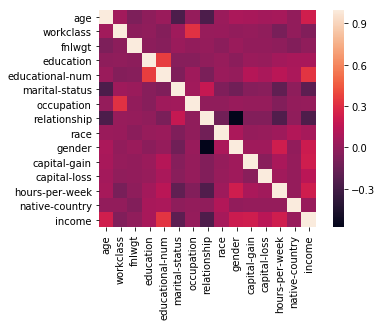

In [6]:
def number_encode_features(df):
    result = df.copy()
    r = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            r[column] = encoders[column].fit_transform(result[column].astype(str))
    return r, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

### One hot encoding

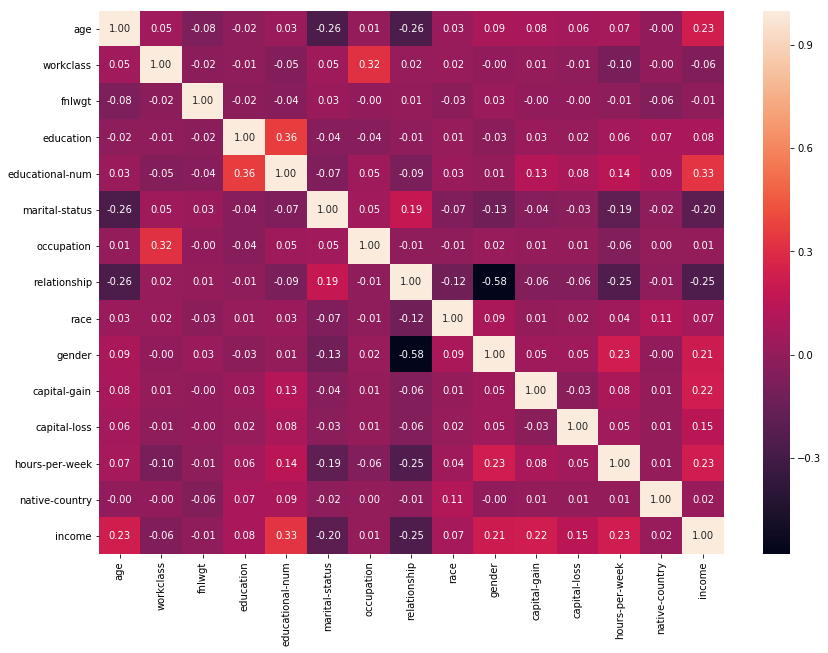

In [7]:
plt.figure(figsize=(14,10))
sns.heatmap(encoded_data.corr(),annot=True,fmt='.2f')
plt.show()

## Target

Female: 1
Male: 0

In [8]:
display(encoded_data[TARGET])

0        0
1        0
2        1
3        1
4        0
5        0
6        0
7        1
8        0
9        0
10       1
11       0
12       0
13       0
14       1
15       1
16       0
17       0
18       0
19       1
20       1
21       0
22       0
23       0
24       0
25       1
26       0
27       0
28       0
29       0
        ..
48812    0
48813    1
48814    1
48815    0
48816    0
48817    1
48818    0
48819    1
48820    1
48821    0
48822    0
48823    0
48824    0
48825    0
48826    1
48827    0
48828    0
48829    0
48830    0
48831    0
48832    0
48833    0
48834    0
48835    1
48836    0
48837    0
48838    1
48839    0
48840    0
48841    1
Name: income, Length: 48842, dtype: int64

In [9]:
# Imprime a porcentagem de false positive e confirmed
display((df[TARGET].value_counts()/len(df)*100).round(2).to_frame(TARGET +" (%)").T)

# Criação de labels binários
df[TARGET] = (df[TARGET] == ">50K").astype(int)

print("Resultado:")
display(df[[TARGET]].sample(10))

,<=50K,>50K
income (%),76.07,23.93


Resultado:


,income
16343,0
28902,0
21714,0
41677,0
8122,0
6151,0
1241,1
43043,0
34868,0
29006,1


Podemos deletar a coluna "education"

In [10]:
df[["education", "educational-num"]].head(15)

,education,educational-num
0,11th,7
1,HS-grad,9
2,Assoc-acdm,12
3,Some-college,10
4,Some-college,10
5,10th,6
6,HS-grad,9
7,Prof-school,15
8,Some-college,10
9,7th-8th,4


In [11]:
del df["education"]

In [12]:
df[["gender", "relationship"]].head(20)

,gender,relationship
0,Male,Own-child
1,Male,Husband
2,Male,Husband
3,Male,Husband
4,Female,Own-child
5,Male,Not-in-family
6,Male,Unmarried
7,Male,Husband
8,Female,Unmarried
9,Male,Husband


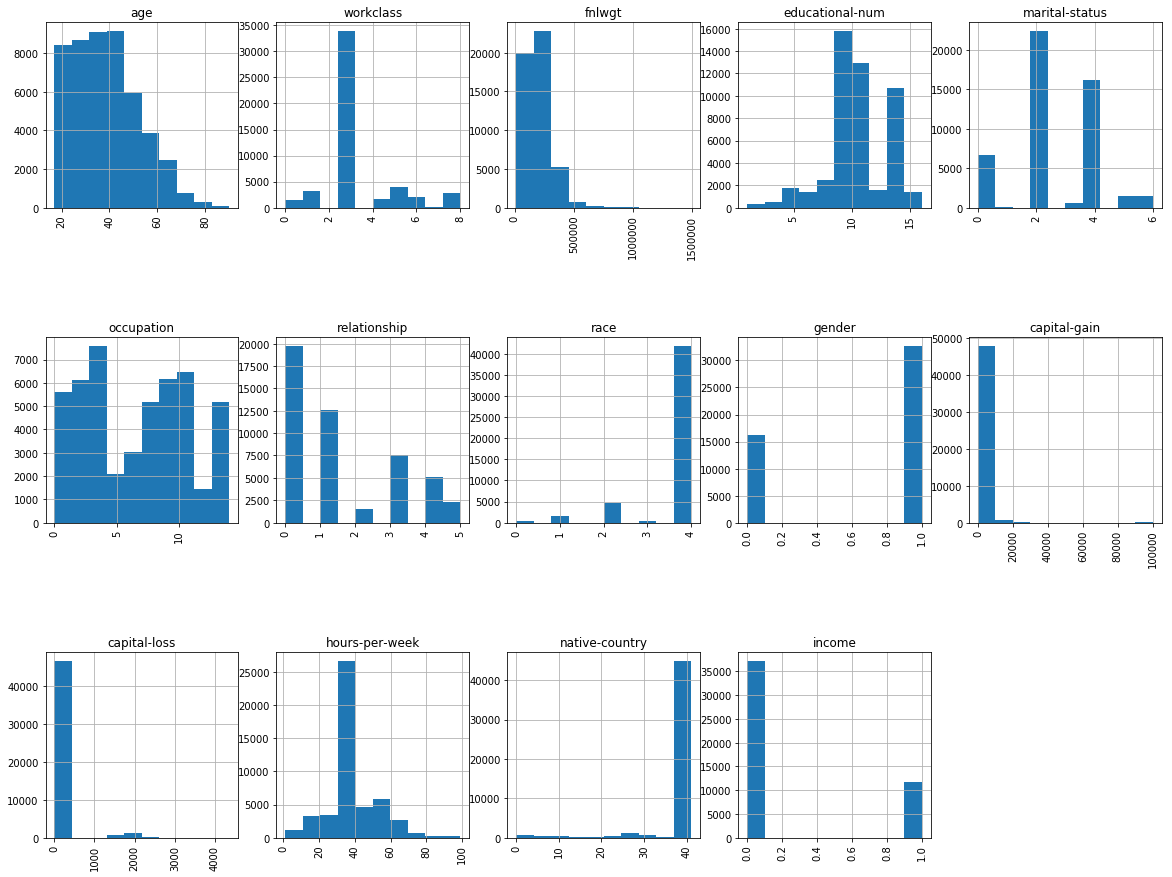

In [15]:
encoded_data, encoders = number_encode_features(df)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [16]:
features = list(encoded_data.columns)
features.remove(TARGET)

print("Target: {}".format(TARGET))
print("Features:")
print("\n".join(["  " + x for x in features]))

Target: income
Features:
  age
  workclass
  fnlwgt
  educational-num
  marital-status
  occupation
  relationship
  race
  gender
  capital-gain
  capital-loss
  hours-per-week
  native-country


In [17]:
encoded_data[features] = encoded_data[features] - encoded_data[features].mean()
encoded_data[features] = encoded_data[features] / encoded_data[features].std()

In [18]:
x = encoded_data[features].values # Seleciona apenas as colunas das features que selecionamos na célula anterior
y = encoded_data[TARGET].values  
print(len(df)/2)
len_train = int(len(df)/2)
X = x[:len_train]
Y = y[:len_train]

kf = KFold(n_splits = N_FOLDS, random_state = 1, shuffle = False)

for train_index, val_index in kf.split(X, Y):
    print("TRAIN:", train_index, "VAL:", val_index)
    X_train, X_test = X[train_index], X[val_index]
    Y_train, Y_test = Y[train_index], Y[val_index]

24421.0
TRAIN: [ 2443  2444  2445 ... 24418 24419 24420] VAL: [   0    1    2 ... 2440 2441 2442]
TRAIN: [    0     1     2 ... 24418 24419 24420] VAL: [2443 2444 2445 ... 4882 4883 4884]
TRAIN: [    0     1     2 ... 24418 24419 24420] VAL: [4885 4886 4887 ... 7324 7325 7326]
TRAIN: [    0     1     2 ... 24418 24419 24420] VAL: [7327 7328 7329 ... 9766 9767 9768]
TRAIN: [    0     1     2 ... 24418 24419 24420] VAL: [ 9769  9770  9771 ... 12208 12209 12210]
TRAIN: [    0     1     2 ... 24418 24419 24420] VAL: [12211 12212 12213 ... 14650 14651 14652]
TRAIN: [    0     1     2 ... 24418 24419 24420] VAL: [14653 14654 14655 ... 17092 17093 17094]
TRAIN: [    0     1     2 ... 24418 24419 24420] VAL: [17095 17096 17097 ... 19534 19535 19536]
TRAIN: [    0     1     2 ... 24418 24419 24420] VAL: [19537 19538 19539 ... 21976 21977 21978]
TRAIN: [    0     1     2 ... 21976 21977 21978] VAL: [21979 21980 21981 ... 24418 24419 24420]


In [19]:
def plot_curva(x, y1, y2, x_label, y_label):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y1, label= "Training")
    plt.plot(x, y2, label= "Validation")
    # distinção para plotar gráfico da decision tree no ponto em que temos altura ilimitada
    if x_label == "max_depth":
        trainAcc, valAcc ,_,_,_,_= decision_tree(None) 
        plt.plot([20], [trainAcc], 'ro',  ms=15, label = 'No depth limit training(y-axis only)')
        plt.plot([20], [valAcc], 'bo', ms=15, label = 'No depth limit 5-fold validation(y-axis only)')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    

In [20]:
def gradient_boosting(N):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, Y):
            
        classifier = ensemble.GradientBoostingClassifier(n_estimators=N)
        classifier = classifier.fit(X[train], Y[train])

        train_score.append(classifier.score(X[train], Y[train]))
        val_score.append(classifier.score(X[val], Y[val]))

        y_pred = classifier.predict(X[val])
        y_proba = (classifier.predict_proba(X[val]))
        y_probab.extend(y_proba[:,1])
        f1_score.append(metrics.f1_score(Y[val], y_pred))
        recall_score.append(metrics.recall_score(Y[val], y_pred))
        precision_score.append(metrics.precision_score(Y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)
    print("Acuracia de treino do melhor modelo: {:.3}".format(trainAcc))
    print("Acuracia de validação do melhor modelo: {:.3}".format(valAcc))
    return trainAcc, valAcc, recall, f1, precision, y_probab


Acuracia de treino do melhor modelo: 0.763
Acuracia de validação do melhor modelo: 0.763
Acuracia de treino do melhor modelo: 0.763
Acuracia de validação do melhor modelo: 0.763
Acuracia de treino do melhor modelo: 0.805
Acuracia de validação do melhor modelo: 0.805
Acuracia de treino do melhor modelo: 0.807
Acuracia de validação do melhor modelo: 0.807
Acuracia de treino do melhor modelo: 0.831
Acuracia de validação do melhor modelo: 0.829
Acuracia de treino do melhor modelo: 0.841
Acuracia de validação do melhor modelo: 0.841
Acuracia de treino do melhor modelo: 0.843
Acuracia de validação do melhor modelo: 0.842
Acuracia de treino do melhor modelo: 0.846
Acuracia de validação do melhor modelo: 0.845
Acuracia de treino do melhor modelo: 0.848
Acuracia de validação do melhor modelo: 0.847
Acuracia de treino do melhor modelo: 0.849
Acuracia de validação do melhor modelo: 0.848
Acuracia de treino do melhor modelo: 0.851
Acuracia de validação do melhor modelo: 0.849
Acuracia de treino do

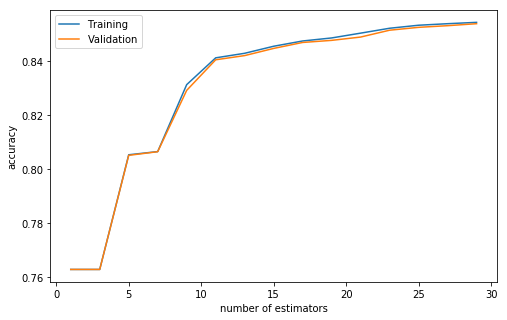

In [22]:
import warnings
warnings.filterwarnings("ignore") #ignore deprecated warnings

acc_modelTrain = []
acc_modelVal = []
n_iter = list(range(1,31,2)) #Valores do número de estimadores a ser variado
for i in n_iter:
    trainAcc, valAcc ,_,_,_,_ = gradient_boosting(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_iter, acc_modelTrain, acc_modelVal, "number of estimators", "accuracy")

In [23]:
def random_forest(N):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, Y):

        classifier = ensemble.RandomForestClassifier(n_estimators=N, max_features=5, min_samples_leaf=50, 
                                                     random_state=24)
        classifier = classifier.fit(X[train], Y[train])

        train_score.append(classifier.score(X[train], Y[train]))
        val_score.append(classifier.score(X[val], Y[val]))

        y_pred = classifier.predict(X[val])
        y_proba = (classifier.predict_proba(X[val]))
        y_probab.extend(y_proba[:,1])
        f1_score.append(metrics.f1_score(Y[val], y_pred))
        recall_score.append(metrics.recall_score(Y[val], y_pred))
        precision_score.append(metrics.precision_score(Y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)
    print("Acuracia de treino do melhor modelo: {:.3}".format(trainAcc))
    print("Acuracia de validação do melhor modelo: {:.3}".format(valAcc))
    
    return trainAcc, valAcc, recall, f1, precision, y_probab

Acuracia de treino do melhor modelo: 0.851
Acuracia de validação do melhor modelo: 0.846
Acuracia de treino do melhor modelo: 0.86
Acuracia de validação do melhor modelo: 0.854
Acuracia de treino do melhor modelo: 0.861
Acuracia de validação do melhor modelo: 0.856
Acuracia de treino do melhor modelo: 0.862
Acuracia de validação do melhor modelo: 0.855
Acuracia de treino do melhor modelo: 0.861
Acuracia de validação do melhor modelo: 0.856
Acuracia de treino do melhor modelo: 0.862
Acuracia de validação do melhor modelo: 0.856
Acuracia de treino do melhor modelo: 0.862
Acuracia de validação do melhor modelo: 0.857
Acuracia de treino do melhor modelo: 0.863
Acuracia de validação do melhor modelo: 0.857
Acuracia de treino do melhor modelo: 0.863
Acuracia de validação do melhor modelo: 0.858
Acuracia de treino do melhor modelo: 0.863
Acuracia de validação do melhor modelo: 0.858
Acuracia de treino do melhor modelo: 0.864
Acuracia de validação do melhor modelo: 0.858
Acuracia de treino do 

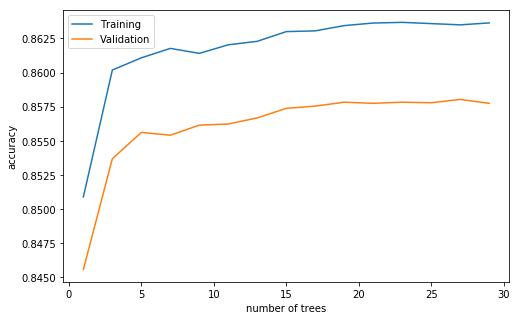

In [24]:
acc_modelTrain = []
acc_modelVal = []
n_trees = list(range(1,31,2)) #Valores do número de árvores a ser variado
for i in n_trees:
    trainAcc, valAcc ,_,_,_,_ = random_forest(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_trees, acc_modelTrain, acc_modelVal, "number of trees", "accuracy")

In [32]:
def knn(k):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, Y):
            
        classifier = neighbors.KNeighborsClassifier(n_neighbors=k)
        classifier = classifier.fit(X[train], Y[train])

        train_score.append(classifier.score(X[train], Y[train]))
        val_score.append(classifier.score(X[val], Y[val]))

        y_pred = classifier.predict(X[val])
        y_proba = (classifier.predict_proba(X[val]))
        y_probab.extend(y_proba[:,1])
        f1_score.append(metrics.f1_score(Y[val], y_pred))
        recall_score.append(metrics.recall_score(Y[val], y_pred))
        precision_score.append(metrics.precision_score(Y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)
    print("Acuracia de treino do melhor modelo: {:.3}".format(trainAcc))
    print("Acuracia de validação do melhor modelo: {:.3}".format(valAcc))
    return trainAcc, valAcc, recall, f1, precision, y_probab

In [ ]:
acc_modelTrain = []
acc_modelVal = []
n_neighbors = list(range(1,21,2)) #Valores do número de vizinhos a ser variado
for i in n_neighbors:
    trainAcc, valAcc ,_,_,_,_ = knn(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(n_neighbors, acc_modelTrain, acc_modelVal, "number of neighbors", "accuracy")


Acuracia de treino do melhor modelo: 1.0
Acuracia de validação do melhor modelo: 0.801
Acuracia de treino do melhor modelo: 0.898
Acuracia de validação do melhor modelo: 0.821
Acuracia de treino do melhor modelo: 0.879
Acuracia de validação do melhor modelo: 0.828
Acuracia de treino do melhor modelo: 0.87
Acuracia de validação do melhor modelo: 0.832
Acuracia de treino do melhor modelo: 0.864
Acuracia de validação do melhor modelo: 0.833
Acuracia de treino do melhor modelo: 0.861
Acuracia de validação do melhor modelo: 0.834
Acuracia de treino do melhor modelo: 0.858
Acuracia de validação do melhor modelo: 0.835
Acuracia de treino do melhor modelo: 0.855
Acuracia de validação do melhor modelo: 0.833


In [25]:
def decision_tree(H):
    train_score = []
    val_score = []
    y_probab = []
    f1_score = []
    recall_score = []
    precision_score = []
        
    for train, val in kf.split(X, Y):
           
        classifier = DecisionTreeClassifier(max_depth= H,max_features=13, min_samples_leaf=100,random_state=10)
        classifier = classifier.fit(X[train], Y[train])

        train_score.append(classifier.score(X[train], Y[train]))
        val_score.append(classifier.score(X[val], Y[val]))

        y_pred = classifier.predict(X[val])
        y_proba = (classifier.predict_proba(X[val]))
        y_probab.extend(y_proba[:,1])
        f1_score.append(metrics.f1_score(Y[val], y_pred))
        recall_score.append(metrics.recall_score(Y[val], y_pred))
        precision_score.append(metrics.precision_score(Y[val], y_pred))

    trainAcc = np.mean(train_score)
    valAcc = np.mean(val_score)
    recall = np.mean(recall_score)
    f1 = np.mean(f1_score)
    precision = np.mean(precision_score)
    print("Acuracia de treino do melhor modelo: {:.3}".format(trainAcc))
    print("Acuracia de validação do melhor modelo: {:.3}".format(valAcc))
    
    return trainAcc, valAcc, recall, f1, precision, y_probab


Acuracia de treino do melhor modelo: 0.763
Acuracia de validação do melhor modelo: 0.763
Acuracia de treino do melhor modelo: 0.838
Acuracia de validação do melhor modelo: 0.838
Acuracia de treino do melhor modelo: 0.851
Acuracia de validação do melhor modelo: 0.85
Acuracia de treino do melhor modelo: 0.853
Acuracia de validação do melhor modelo: 0.851
Acuracia de treino do melhor modelo: 0.853
Acuracia de validação do melhor modelo: 0.851
Acuracia de treino do melhor modelo: 0.855
Acuracia de validação do melhor modelo: 0.85
Acuracia de treino do melhor modelo: 0.857
Acuracia de validação do melhor modelo: 0.851
Acuracia de treino do melhor modelo: 0.857
Acuracia de validação do melhor modelo: 0.85
Acuracia de treino do melhor modelo: 0.857
Acuracia de validação do melhor modelo: 0.85
Acuracia de treino do melhor modelo: 0.857
Acuracia de validação do melhor modelo: 0.85
Acuracia de treino do melhor modelo: 0.857
Acuracia de validação do melhor modelo: 0.85


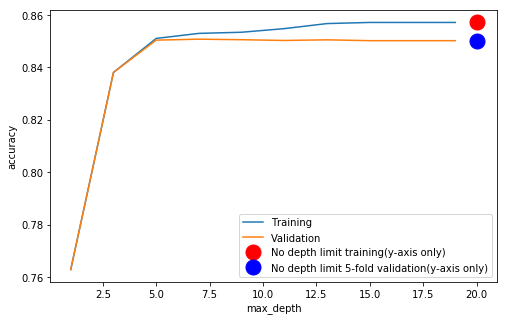

In [26]:
acc_modelTrain = []
acc_modelVal = []
max_depth = list(range(1,21,2)) #Valores usados para variar a altura da árvore 
for i in max_depth:
    trainAcc, valAcc ,_,_,_,_ = decision_tree(i)    
    acc_modelTrain.append(trainAcc)
    acc_modelVal.append(valAcc)
plot_curva(max_depth, acc_modelTrain, acc_modelVal, "max_depth", "accuracy")

In [27]:
model = Sequential()
# fully connected layer
model.add(Dense(8, activation='relu', input_dim = 13))
#model.add(Dense(50, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 112       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [29]:
for train, val in kf.split(X, Y):
    response = model.fit(X[train], Y[train], validation_data=(X[val], Y[val]), batch_size=500, epochs=2
                         , verbose=1)
    #score = model.evaluate(X_test, Y_test, verbose=1)
    #print(score)
    print('\n')

Instructions for updating:
Use tf.cast instead.
Train on 21978 samples, validate on 2443 samples
Epoch 1/2
21978/21978 [==============================] - 0s 12us/step - loss: 0.8880 - acc: 0.5429 - val_loss: 0.7158 - val_acc: 0.5731
Epoch 2/2
21978/21978 [==============================] - 0s 2us/step - loss: 0.7460 - acc: 0.6049 - val_loss: 0.6082 - val_acc: 0.6590


Train on 21979 samples, validate on 2442 samples
Epoch 1/2
21979/21979 [==============================] - 0s 2us/step - loss: 0.6536 - acc: 0.6503 - val_loss: 0.5385 - val_acc: 0.7334
Epoch 2/2
21979/21979 [==============================] - 0s 2us/step - loss: 0.5881 - acc: 0.6914 - val_loss: 0.4897 - val_acc: 0.7686


Train on 21979 samples, validate on 2442 samples
Epoch 1/2
21979/21979 [==============================] - 0s 3us/step - loss: 0.5525 - acc: 0.7216 - val_loss: 0.4706 - val_acc: 0.7699
Epoch 2/2
21979/21979 [==============================] - 0s 3us/step - loss: 0.5178 - acc: 0.7468 - val_loss: 0.4503 - val_ac

In [30]:
X_test = x[len_train:]
Y_test = y[len_train:]
score = model.evaluate(X_test, Y_test, verbose=1)

24421/24421 [==============================] - 0s 10us/step


In [31]:
print(score)

[0.37132134770986797, 0.833012571152664]
